## ViT Training##
In this notebook, we will use CIFAR10 dataset to train a ViT model. CIFAR10 is a dataset with 60,000 pictures of 32x32 pixel. we will use these pictures and make a classification model of 10 classes. For more info, read the README.md file in the github repository this notebook is posted on. link: https://github.com/chapi1420/vit-classificaiton

### logging
this is done to track every actions we perform in this notebook. the log file that shows report on the training is in link: https://github.com/chapi1420/vit-classificaiton/blob/master/vit_training.log

# Components and Their Uses in Vision Transformer (ViT) Training

## 1. Patch Embedding
- **Purpose**: Converts images into patches to be processed by the transformer.
- **Use**: Each image is divided into smaller patches, and a linear embedding is applied to each patch. This allows the model to learn spatial hierarchies and relationships within the image.

## 2. Multi-Head Self-Attention
- **Purpose**: Enables the model to focus on different parts of the image simultaneously.
- **Use**: By using multiple attention heads, the model can capture various features and dependencies, improving its ability to understand complex patterns in the data.

## 3. Transformer Encoder Block
- **Purpose**: Processes the embedded patches through layers of self-attention and feed-forward networks.
- **Use**: Each encoder block refines the representation of the input patches, allowing the model to learn high-level features and relationships within the image.

## 4. MLP Head
- **Purpose**: Acts as the final classification layer.
- **Use**: Takes the output from the transformer encoder and processes it through a multi-layer perceptron (MLP) to produce class probabilities for tasks such as image classification.

## 5. Training Loops
- **Purpose**: Manages the training process, including forward and backward passes.
- **Use**: Implements optimization algorithms (like AdamW), learning rate scheduling, and checkpoint saving to ensure effective training and model performance tracking.

## 6. Validation Accuracy Tracking
- **Purpose**: Monitors the model's performance on validation data.
- **Use**: Helps in determining when to stop training (early stopping) and tuning hyperparameters based on validation results.

## 7. Log Files
- **Purpose**: Records all experiments, including hyperparameters and metrics.
- **Use**: Provides a comprehensive history of training runs, which is essential for reproducibility and debugging.

## 8. Checkpointing
- **Purpose**: Saves model weights at certain intervals.
- **Use**: Allows resuming training from a specific point in case of interruptions, and helps in selecting the best model based on validation performance.

## 9. Data Augmentation
- **Purpose**: Enhances the training dataset by creating variations of the input images.
- **Use**: Improves model generalization by exposing it to a wider range of data, helping to reduce overfitting.

## 10. Hyperparameter Tuning
- **Purpose**: Optimizes model performance by adjusting parameters such as learning rate, batch size, and number of epochs.
- **Use**: Involves systematic experimentation to find the best settings for training, leading to improved accuracy and efficiency.

---

These components collectively contribute to the effectiveness of the Vision Transformer architecture in image classification tasks, enabling it to learn complex patterns and achieve high performance on datasets like CIFAR-10.


In [70]:
import logging
from datetime import datetime

# Create and configure logger
log_file = "vit_training.log"
logging.basicConfig(
    filename=log_file,
    filemode='a',
    format='%(asctime)s - %(levelname)s - %(message)s',
    level=logging.INFO
)

# Initial log
logging.info("==== Starting Vision Transformer Project ====")


In [ ]:
logging.info("Moved to Google Colab for GPU support. Environment initialized.")


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import logging
from datetime import datetime


### logging
This code sets up and preprocesses the CIFAR-10 dataset for image classification training. It logs the initialization process, defines normalization parameters based on the dataset's statistics, and applies data augmentation techniques such as random horizontal flipping and cropping to enhance the training data. The code then downloads the CIFAR-10 dataset, applies the specified transformations, and creates DataLoader instances for both training and validation sets, enabling efficient batch processing and shuffling. Finally, it logs the successful loading of the datasets, providing feedback on the number of images prepared for training and validation.


In [ ]:

# Log the step
logging.info("Setting up CIFAR-10 dataset and DataLoaders with standard normalization.")

# Define transforms
cifar10_mean = [0.4914, 0.4822, 0.4465]
cifar10_std = [0.2471, 0.2435, 0.2616]

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar10_mean, std=cifar10_std)
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar10_mean, std=cifar10_std)
])

# Download and load the CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

# Log success
logging.info(f"Loaded CIFAR-10 dataset: {len(train_dataset)} training images, {len(val_dataset)} validation images.")


### visualization
This code snippet visualizes a batch of images from the CIFAR-10 dataset using Matplotlib. It defines a helper function, `imshow`, which unnormalizes the image tensors by reversing the normalization applied during preprocessing (using the mean and standard deviation specific to CIFAR-10). The function then converts the tensor to a NumPy array and displays the images. The code retrieves one batch of images and their corresponding labels from the training DataLoader, and it uses the `torchvision.utils.make_grid` function to arrange the first eight images in a grid format before passing them to the `imshow` function for visualization.


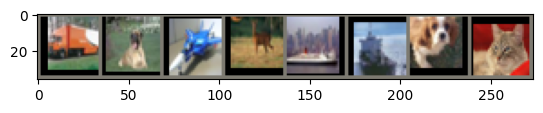

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Helper to unnormalize
def imshow(img):
    img = img * torch.tensor(cifar10_std).view(3,1,1) + torch.tensor(cifar10_mean).view(3,1,1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get one batch
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:8]))


###patch embedding
This code defines a `PatchEmbedding` class, which is a key component of the Vision Transformer (ViT) architecture. The class inherits from `nn.Module` and initializes several important parameters, including the size of the image, patch size, input channels, and embedding dimension. In the `forward` method, the input tensor is processed through the following steps:

1. **Patch Splitting**: The input image is divided into non-overlapping patches using the `unfold` method, reshaped, and permuted to prepare it for embedding.
2. **Linear Projection**: Each flattened patch is projected into a higher-dimensional space defined by `embed_dim` using a linear layer.
3. **[CLS] Token Addition**: A learnable classification token (`cls_token`) is concatenated to the beginning of the sequence of patch embeddings.
4. **Positional Embedding Addition**: Positional embeddings are added to the sequence to retain spatial information, ensuring that the model can differentiate between the positions of the patches.

The output of the `forward` method is a tensor containing the embedded patches along with the [CLS] token, ready for further processing in the transformer encoder layers.


In [ ]:
import torch
import torch.nn as nn

class PatchEmbedding(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, embed_dim=128):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2

        # Linear projection of flattened patches
        self.proj = nn.Linear(patch_size * patch_size * in_channels, embed_dim)

        # [CLS] token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        # Positional embeddings for [CLS] + all patches
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))

    def forward(self, x):
        B, C, H, W = x.shape  # batch, channels, height, width

        # Step 1: Split into patches
        x = x.unfold(2, self.patch_size, self.patch_size)
        x = x.unfold(3, self.patch_size, self.patch_size)
        x = x.contiguous().view(B, C, -1, self.patch_size, self.patch_size)
        x = x.permute(0, 2, 1, 3, 4).contiguous()
        x = x.view(B, self.num_patches, -1)

        # Step 2: Project to embed_dim
        x = self.proj(x)

        # Step 3: Add [CLS] token
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # Step 4: Add positional embeddings
        x = x + self.pos_embed

        return x


In [ ]:
patch_embed = PatchEmbedding()
dummy_input = torch.randn(8, 3, 32, 32)

output = patch_embed(dummy_input)

print("Patch Embed output shape:", output.shape)


Patch Embed output shape: torch.Size([8, 65, 128])


In [ ]:
logging.info("Implemented PatchEmbedding module with CLS token and positional embeddings.")


### transformer encoder block
The `TransformerEncoderBlock` class implements a single encoder block of the Vision Transformer (ViT) architecture, inheriting from `nn.Module`. It consists of two main components: a multi-head self-attention mechanism and a feedforward neural network (MLP).

1. **Initialization**: The constructor initializes the multi-head attention layer with specified embedding dimensions, number of attention heads, and dropout rate. It also sets up layer normalization and dropout for both the attention output and the MLP.

2. **Forward Method**:
   - **Attention Block**: The input tensor `x` undergoes multi-head self-attention, where it attends to itself to capture relationships between different patches. The output is then added to the original input (residual connection) and normalized using layer normalization.
   - **MLP Block**: The normalized output is passed through a feedforward network consisting of two linear layers with a GELU activation function in between. After processing through the MLP, another residual connection is applied, followed by layer normalization.

The output of the `forward` method is the transformed representation of the input, which can be fed into subsequent layers of the transformer model.


In [ ]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim=128, num_heads=4, mlp_dim=512, dropout=0.1):
        super(TransformerEncoderBlock, self).__init__()

        # Multi-head self-attention
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout)

        # MLP block (Feedforward network)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout)
        )
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # Attention block
        attn_output, _ = self.attn(x, x, x)
        x = self.norm1(x + self.dropout1(attn_output))

        # MLP block
        mlp_output = self.mlp(x)
        x = self.norm2(x + mlp_output)

        return x


In [ ]:
encoder_block = TransformerEncoderBlock()
dummy_input = torch.randn(8, 65, 128)  # [B, num_patches + 1, embed_dim]
out = encoder_block(dummy_input)
print("Transformer block output shape:", out.shape)


Transformer block output shape: torch.Size([8, 65, 128])


In [ ]:
logging.info("Implemented single TransformerEncoderBlock with multi-head attention and MLP.")


### vision transformer
The `VisionTransformer` class defines the architecture of a Vision Transformer (ViT) model for image classification. It inherits from `nn.Module` and comprises several key components:

1. **Initialization**:
   - The constructor initializes the `PatchEmbedding` layer to convert input images into patch embeddings.
   - It creates a list of `TransformerEncoderBlock` instances, allowing for a specified number of transformer blocks (`num_transformer_blocks`).
   - A layer normalization layer is added to normalize the output of the transformer blocks, and a fully connected layer (`fc`) is defined to map the output to the number of classes.

2. **Forward Method**:
   - The input image tensor `x` is first passed through the `patch_embed` layer to obtain patch embeddings.
   - Each transformer block processes the embeddings in sequence, capturing complex relationships between patches.
   - After processing through all transformer blocks, the output corresponding to the [CLS] token (the first token in the sequence) is extracted.
   - This output is normalized and then passed through the fully connected layer to produce the final class predictions.

The output of the `forward` method is the predicted class scores for the input image, making the model suitable for classification tasks.


In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, embed_dim=128,
                 num_transformer_blocks=6, num_heads=4, mlp_dim=512, num_classes=10,
                 dropout=0.1):
        super(VisionTransformer, self).__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.transformer_blocks = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, mlp_dim, dropout)
            for _ in range(num_transformer_blocks)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)

        for block in self.transformer_blocks:
            x = block(x)

        # Take the [CLS] token output
        cls_token_output = x[:, 0]

        x = self.norm(cls_token_output)
        x = self.fc(x)
        return x

In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformer().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)

# Learning rate scheduler with cosine annealing
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

logging.info("Set up AdamW optimizer and cosine annealing LR scheduler.")




### `train_one_epoch` Function
- **Purpose**: This function trains the model for one epoch using the provided data loader.
- **Parameters**:
  - `model`: The Vision Transformer model to be trained.
  - `loader`: DataLoader for the training dataset.
  - `criterion`: Loss function used to compute the loss.
  - `optimizer`: Optimizer for updating model weights.
  - `device`: Device (CPU or GPU) where the computation will take place.
- **Process**:
  - The model is set to training mode.
  - It iterates over the training data, transferring images and labels to the specified device.
  - For each batch, it computes the model's outputs, calculates the loss, and performs backpropagation.
  - The running loss and accuracy are updated for each batch.
- **Returns**: The average loss and accuracy for the epoch.

### `validate` Function
- **Purpose**: This function evaluates the model on the validation dataset.
- **Parameters**:
  - Similar to `train_one_epoch`, but for validation purposes.
- **Process**:
  - The model is set to evaluation mode, and gradients are not computed to save memory.
  - It iterates over the validation data, computing the outputs and loss without updating the model weights.
- **Returns**: The average validation loss and accuracy.

These functions are crucial for monitoring the model's performance during training and validation phases, allowing for adjustments to be made as necessary.


In [ ]:
from tqdm import tqdm

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


def validate(model, loader, criterion, device):
    model.eval()
    val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    return val_loss / total, correct / total


In [ ]:
epoch_options = [10, 20, 30]
all_train_losses = []
all_val_losses = []
all_train_accs = []
all_val_accs = []




### Main Training Loop

1. **Epoch Options**: The loop iterates over different epoch configurations defined in `epoch_options`, allowing for flexible training durations.

2. **Model Initialization**:
   - A new instance of the `VisionTransformer` model is created and moved to the specified device (CPU or GPU).
   - The optimizer (`AdamW`) is initialized with a learning rate of \(3 \times 10^{-4}\) and a weight decay of \(0.01\).
   - A learning rate scheduler (`CosineAnnealingLR`) is set up to adjust the learning rate over the course of training.

3. **Metrics Storage**: Lists are initialized to keep track of training and validation losses and accuracies for each epoch.

4. **Training and Validation Loop**:
   - For each epoch, the model is trained using the `train_one_epoch` function, and validation is performed using the `validate` function.
   - The learning rate scheduler is updated at the end of each epoch.

5. **Logging and Checkpointing**:
   - If the validation accuracy exceeds the best recorded accuracy, the model's state is saved to a file named `best_vit_{max_epochs}ep.pth`.
   - Logging statements provide feedback on the progress of training and any improvements in validation accuracy.

6. **Metrics Storage for Plotting**: After each training run, the losses and accuracies for both training and validation are appended to respective lists for later analysis.

7. **Completion Log**: At the end of the training for the specified number of epochs, a log message indicates that training has finished.

### Summary
This code effectively manages the training process of a Vision Transformer model, ensuring that performance metrics are tracked and the best model is saved for future use. The use of logging provides visibility into the training progress, which is essential for debugging and optimization.


In [ ]:
for max_epochs in epoch_options:
    logging.info(f"Starting training for {max_epochs} epochs.")

    model = VisionTransformer().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_acc = 0

    for epoch in range(max_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        scheduler.step()

        # Logging and checkpoint
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"checkpoints/best_vit_{max_epochs}ep.pth")
            logging.info(f"[{max_epochs} epochs] Epoch {epoch}: New best val_acc={val_acc:.4f}")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

    # Save metrics for plotting later
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_accs.append(train_accs)
    all_val_accs.append(val_accs)

    logging.info(f"Finished training for {max_epochs} epochs.")


Training: 100%|██████████| 782/782 [00:30<00:00, 25.89it/s]



### Plotting Loss and Accuracy Curves

1. **Importing Matplotlib**: The `matplotlib.pyplot` library is imported for creating the plots.

2. **Creating the Figure**:
   - A figure with a size of 10 inches by 4 inches is initialized.
   - Two subplots are created side by side for loss and accuracy visualization.

3. **Plotting Loss**:
   - In the first subplot, the training loss and validation loss are plotted against the number of epochs.
   - The plot is titled "Loss Curve", and labels for the x-axis ("Epoch") and y-axis ("Loss") are set.
   - A legend is added to differentiate between training and validation loss.

4. **Plotting Accuracy**:
   - In the second subplot, the training accuracy and validation accuracy are plotted similarly.
   - This plot is titled "Accuracy Curve", with appropriate x and y labels.
   - A legend is included for clarity.

5. **Layout Adjustment**: `plt.tight_layout()` is called to improve the spacing between subplots, ensuring that labels and titles are not overlapping.

6. **Displaying the Plot**: `plt.show()` renders the plots, allowing for visual inspection of the model's performance over epochs.

7. **Logging**: A log message indicates that the training and validation curves have been successfully plotted.

### Summary
This visualization helps in understanding the model's learning behavior throughout the training process. By examining the loss and accuracy curves, one can identify trends such as overfitting, underfitting, or convergence patterns, which are critical for model evaluation and optimization.


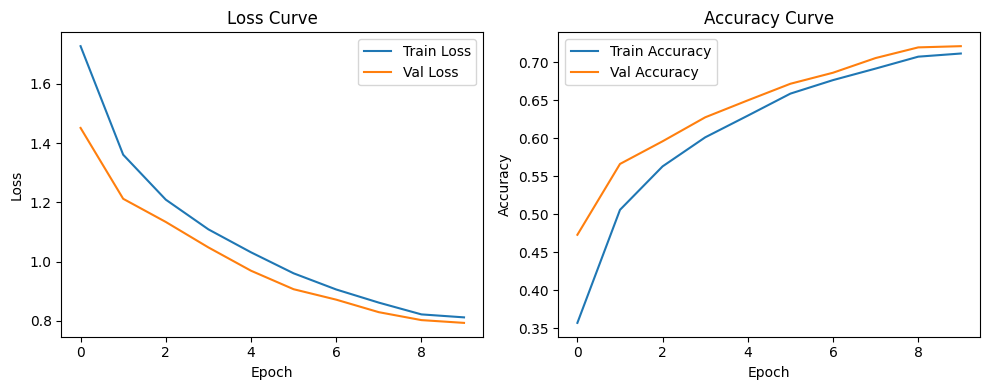

In [ ]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

logging.info("Plotted training and validation loss/accuracy curves.")


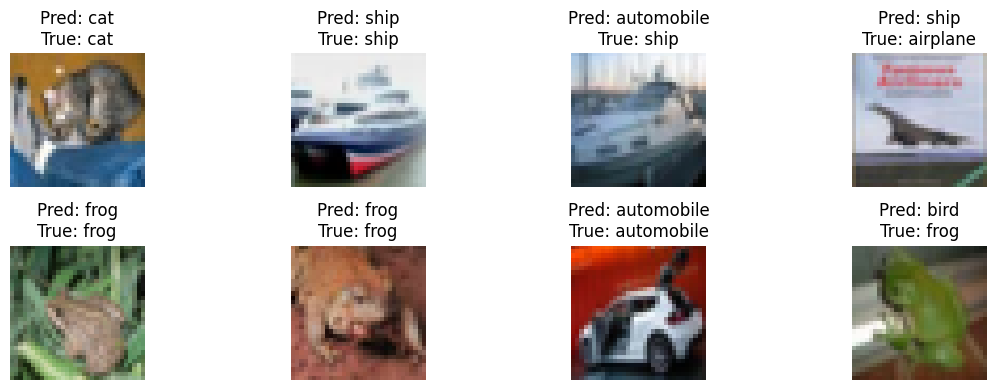

In [ ]:
classes = train_dataset.classes

def show_predictions(model, loader, device, num_images=8):
    model.eval()
    images_shown = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            plt.figure(figsize=(12, 4))
            for i in range(num_images):
                img = images[i].cpu()
                img = img * torch.tensor(cifar10_std).view(3, 1, 1) + torch.tensor(cifar10_mean).view(3, 1, 1)
                img = img.permute(1, 2, 0).numpy()

                plt.subplot(2, 4, i+1)
                plt.imshow(img)
                plt.title(f"Pred: {classes[preds[i]]}\nTrue: {classes[labels[i]]}")
                plt.axis('off')

            plt.tight_layout()
            plt.show()
            break

show_predictions(model, val_loader, device)
logging.info("Displayed example predictions from the validation set.")


In [71]:
with open("vit_training.log", "w") as f:
    for i, e in enumerate(epoch_options):
        f.write(f"Run: {e} epochs\n")
        for ep in range(len(all_train_losses[i])):
            f.write(f"Epoch {ep}: "
                    f"Train Loss = {all_train_losses[i][ep]:.4f}, "
                    f"Val Loss = {all_val_losses[i][ep]:.4f}, "
                    f"Train Acc = {all_train_accs[i][ep]:.4f}, "
                    f"Val Acc = {all_val_accs[i][ep]:.4f}\n")
        f.write("\n")


In [72]:
from google.colab import files
files.download("vit_training.log")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [73]:
torch.save(model.state_dict(), f"best_vit_{max_epochs}ep.pth")


In [74]:
!zip vit_checkpoints.zip best_vit_10ep.pth best_vit_20ep.pth best_vit_30ep.pth
files.download("vit_checkpoints.zip")


	zip warning: name not matched: best_vit_10ep.pth
	zip warning: name not matched: best_vit_20ep.pth
  adding: best_vit_30ep.pth (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>